# Structure of the notebook

This notebook analyzes yellow taxi trip records from January to June 2022 in New York City (NYC).
The dataset was retrieved from the [New York City Taxi and Limousine Commission (TLC)](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) and provides information on: <br>
<ul>
    <li>tpep_pickup_datetime: The date and time when the taximeter was engaged </li>
    <li>tpep_dropoff_datetime: The date and time when the taximeter was disengaged)</li>
    <li>PULocationID: The location (taxi zone), where the taximeter was engaged)</li>
    <li>DOLocationID: The location (taxi zone), where the taximeter was disengaged</li>
    <li>passenger_count: The number of passengers in the vehicle (driver-entered value)</li>
    <li>trip_distance: The elapsed trip distance in miles</li>
    <li>total_amount: The total amount charged to passengers (cash tips excluded)</li>
</ul>

The notebook sets the basis for **Chapter 3.2 Data Cleaning:** <br>
<ul>
    <li> Missing Value Analysis (Chapter 3.2.1)</li>
    <li> Outlier Analysis (Chapter 3.2.2)</li>
</ul>

# Libraries required to run this notebook

In [1]:
# Load the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker
import seaborn as sns
import statistics
import warnings
warnings.filterwarnings("ignore")

# Data reading and initial exploration

In [2]:
# Load the data

taxi_data = pd.read_parquet("gs://taxi_trip_records", columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'total_amount'])

In [3]:
# First five rows of the dataframe

taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount
0,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,142,236,21.95
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,236,42,13.30
2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,166,166,10.56
3,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,114,68,11.80
4,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,68,163,30.30


In [4]:
# Last five rows of the dataframe

taxi_data.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount
19817578,2022-06-30 23:45:51,2022-06-30 23:51:48,NaN,0.00,148,256,15.00
19817579,2022-06-30 23:25:00,2022-06-30 23:40:00,NaN,5.01,79,262,27.35
19817580,2022-06-30 23:29:00,2022-06-30 23:37:00,NaN,1.55,164,79,16.43
19817581,2022-06-30 23:24:15,2022-06-30 23:50:19,NaN,5.30,211,239,27.64
19817582,2022-06-30 23:33:53,2022-06-30 23:54:58,NaN,4.41,255,158,24.46


In [5]:
# Shape of the dataframe

taxi_data.shape

(19817583, 7)

In [6]:
# Datatypes of the columns

taxi_data.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
PULocationID                      int64
DOLocationID                      int64
total_amount                    float64
dtype: object

# Data cleaning

Following an initial exploration of the dataset, further examination is conducted to identify any missing or duplicate values, as well as outliers in the data.

## Missing value analysis

In [7]:
# Identification of missing values in the dataset

taxi_data.isna().sum()

tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          671901
trip_distance                 0
PULocationID                  0
DOLocationID                  0
total_amount                  0
dtype: int64

In [8]:
# Identification of duplicate values in the dataset

taxi_data.duplicated().sum()

0

**Findings:** <br>The column **passenger_count** contains 671,901 missing values. Trips records with missing values will be removed from the dataset.
No duplicate values were detected.

In [9]:
# Removal of missing values

taxi_data_shape = taxi_data.shape[0]
taxi_data_na = taxi_data.dropna()
print("Total number of outliers removed: ", taxi_data_shape - taxi_data_na.shape[0])
print("Shape of the new DataFrame: ", taxi_data_na.shape)

Total number of outliers removed:  671901
Shape of the new DataFrame:  (19145682, 7)


## Outlier analysis

### Descriptive summary statistics

In [10]:
taxi_data_na.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount
count,19145682.00000,19145682.00000,19145682.00000,19145682.00000,19145682.00000
mean,1.39674,3.38583,165.02860,163.18301,20.66693
std,0.97234,51.18058,65.12097,70.20976,130.45682
min,0.00000,0.00000,1.00000,1.00000,-2567.80000
25%,1.00000,1.10000,132.00000,113.00000,11.80000
50%,1.00000,1.83000,162.00000,162.00000,15.36000
75%,1.00000,3.38000,234.00000,234.00000,21.80000
max,9.00000,184340.80000,265.00000,265.00000,401095.62000


**Findings:** <br>

<ul>
    <li>passenger_count: The dataset contains trips where no passenger was on board. The maximum value of 9 appears inplausibly high.</li>
    <li> PULocationID and DOLocationID: According to the TLC *, there are only 263 different LocationIDs. LocationIDs 264 and 265 represent trips where the pickup/dropoff location is unknown. These records will be removed from the dataset in the final outlier removal process.</li>
    <li>trip_distance: The dataset contains records where trip distance equals zero miles. The maximum trip distance appears unreasonably high. The high standard deviation indicates great variability in the data.</li>
    <li>total_amount: Certain trips in the dataset have a negative payment amount. In addition, the maximum payment is very large. The high standard deviation indicates great variability in the data </li>
</ul>

Source: [TLC](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

### In-depth examination of explanatory feature distributions

----------------------
#### Passenger Count
----------------------

In [11]:
# Basic statistics

print("Mean Passenger Count: ", statistics.mean(taxi_data_na['passenger_count']))
print("Median Passenger Count: ", statistics.median(taxi_data_na['passenger_count']))

Mean Passenger Count:  1.3967362980331544
Median Passenger Count:  1.0


In [12]:
# Frequency table

pd.crosstab(index = taxi_data_na['passenger_count'], columns = 'count')

col_0,count
passenger_count,
0.0,403221
1.0,14204666
2.0,2864197
3.0,745800
4.0,315039
5.0,366019
6.0,246538
7.0,105
8.0,78


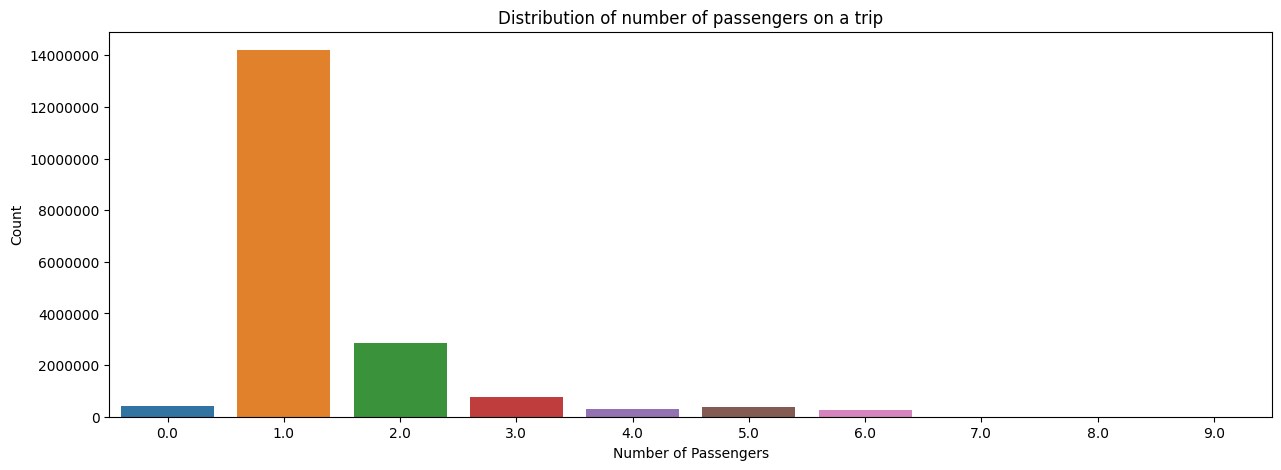

In [13]:
# Distribution of number of passengers on a trip

f = plt.figure(figsize = (15,5))
sns.countplot(x = 'passenger_count', data = taxi_data_na)
plt.title('Distribution of number of passengers on a trip')
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.show()

**Findings:** <br> The majority of trips had only one passenger, while trips with more than six passengers were rare occurrences. It is decided to discard observations outside the range from 1 to 6 in the final outlier removal process.

----------------------
#### LocationIDs
----------------------

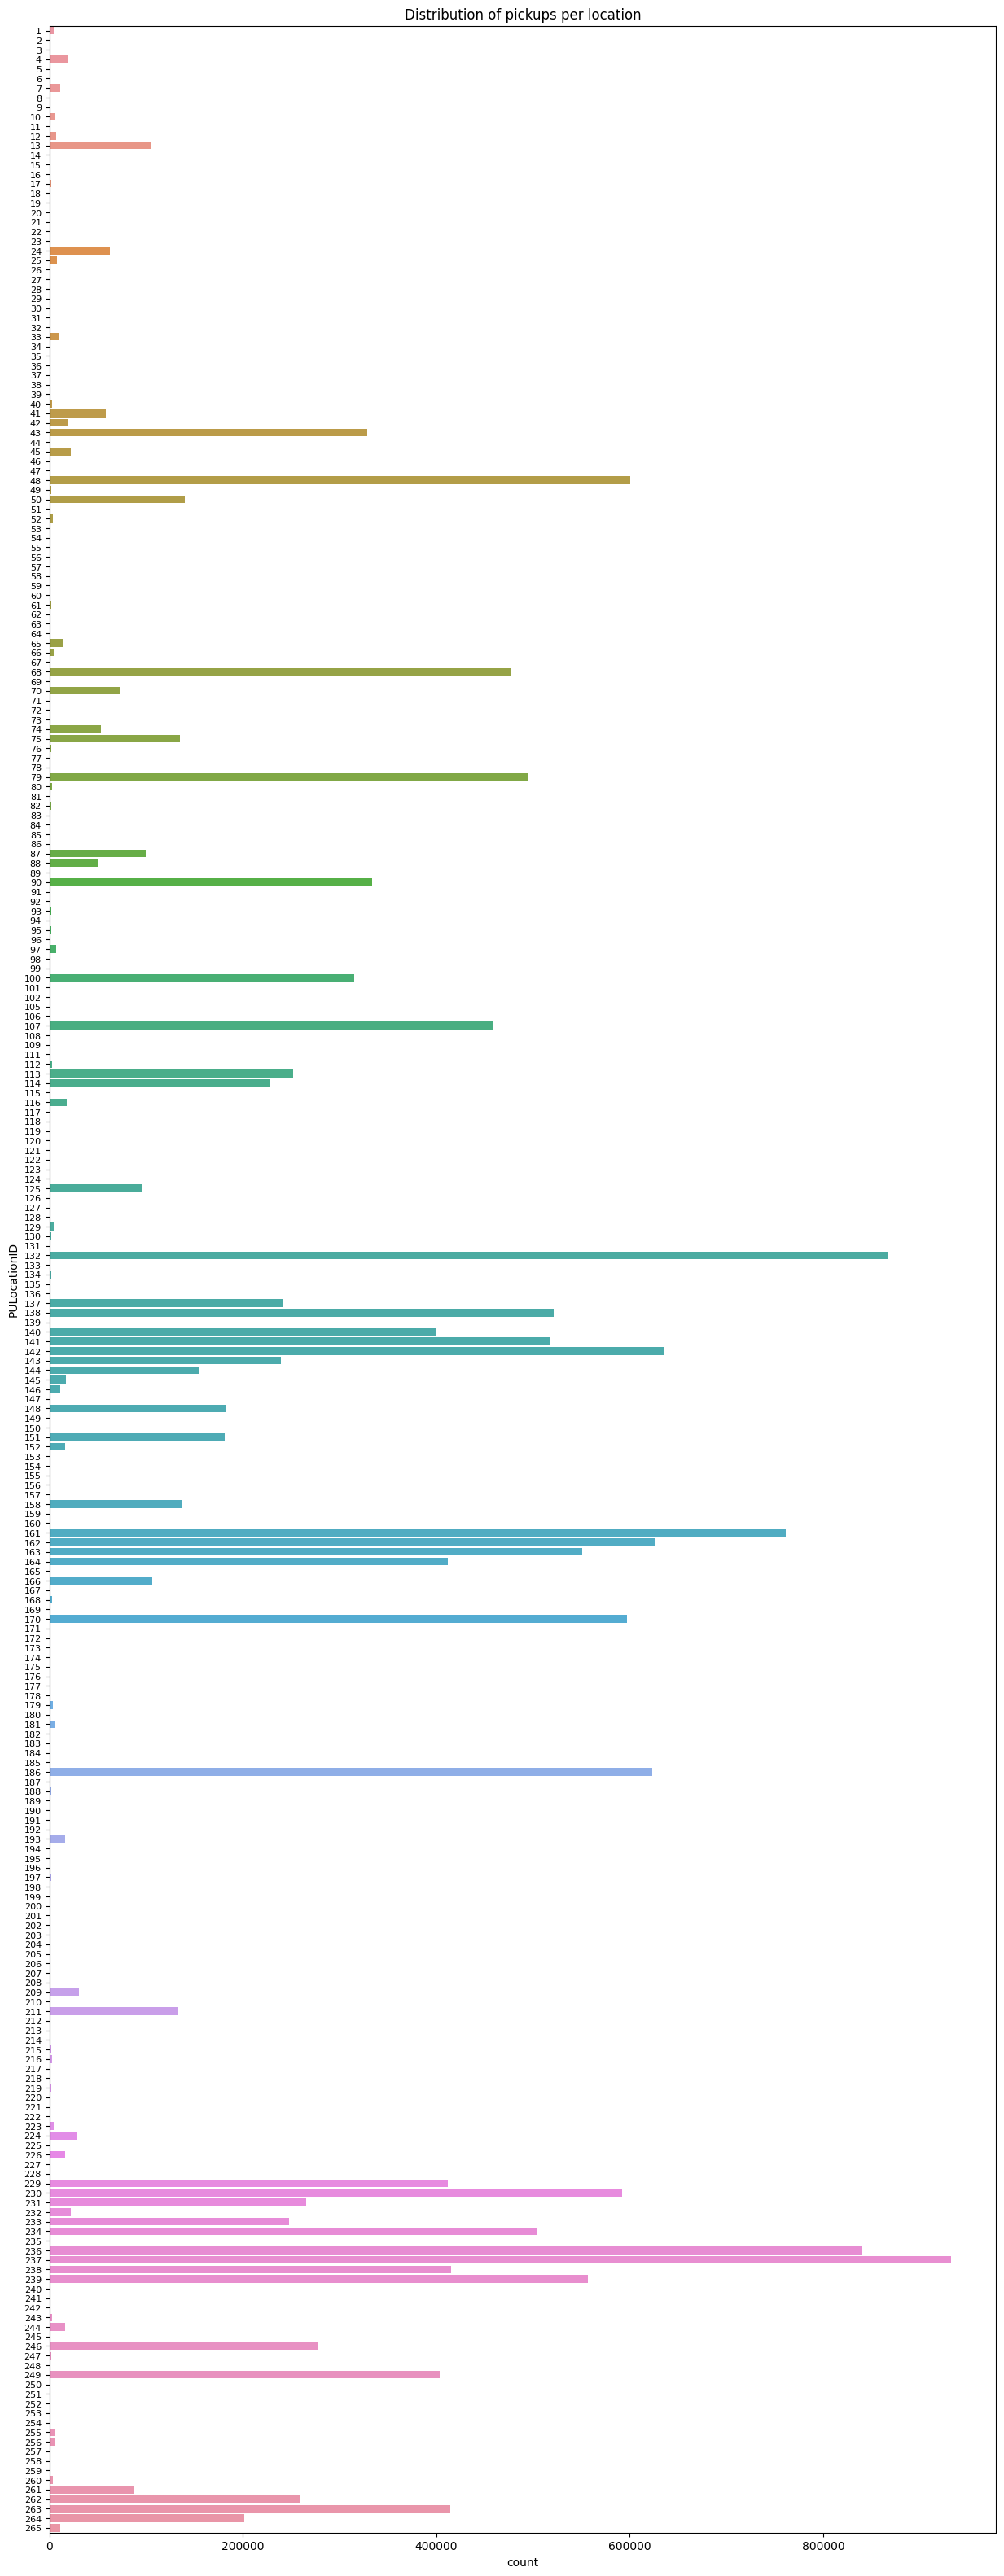

In [14]:
# Distribution of pickups per location

f = plt.figure(figsize = (15,40))
sns.countplot(data = taxi_data_na, y = 'PULocationID')

plt.title('Distribution of pickups per location')
plt.yticks(fontsize =8)
plt.show()

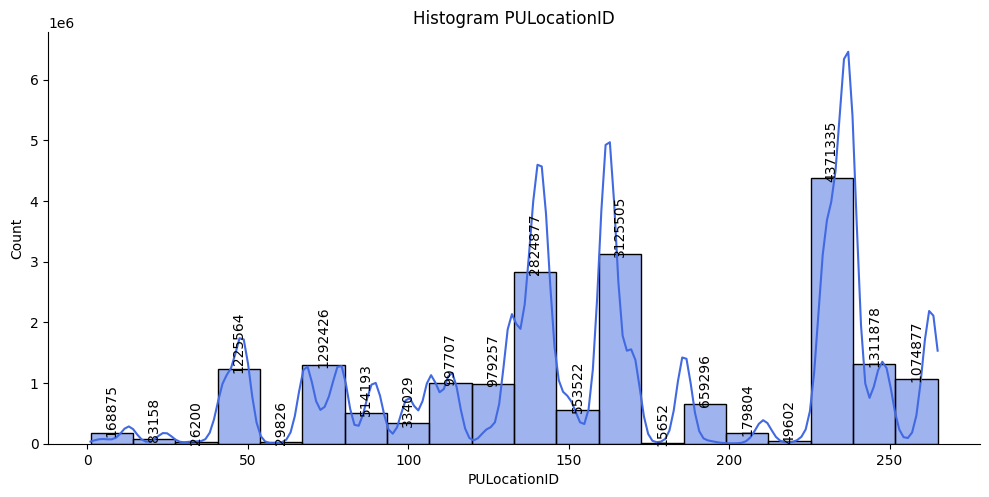

In [15]:
# Histogram of pickups per location

ax = sns.displot(taxi_data['PULocationID'], bins = 20, aspect = 2, height = 5, kde = True, color = 'royalblue')

plt.title("Histogram PULocationID")
plt.xlabel("PULocationID")
plt.ylabel("Count")

for p in ax.ax.patches: 
    height = p.get_height()
    # adding text to each bar
    ax.ax.text(x = p.get_x()+ (p.get_width()/2),
               y = height+0.2,
               s = '{:.0f}'.format(height),
               ha = 'center', rotation = 90)
plt.show()

**Findings:**<br>
It is observed that some locations have a higher taxi demand, whereas other locations barely request any rides. The histogram of PULocationID demonstrates that there are three hotspot areas with an exceptional high demand.

----------------------
##### Trip distance
----------------------

In [16]:
# Basic statistics

print(taxi_data_na['trip_distance'].mean())
print(taxi_data_na['trip_distance'].median())
print(taxi_data_na['trip_distance'].kurt()) # The higher the kurtosis is often linked to the greater extremity or deviations in the data.

3.385826471472776
1.83
9923308.527619703


In [17]:
# Trip distance values and frequencies

taxi_data_na['trip_distance'].value_counts().sort_index()

0.00         229456
0.01          14898
0.02          10081
0.03           7891
0.04           6124
              ...  
7496.85           1
29445.65          1
53440.55          1
108786.09         1
184340.80         1
Name: trip_distance, Length: 6538, dtype: int64

<Figure size 200x400 with 0 Axes>

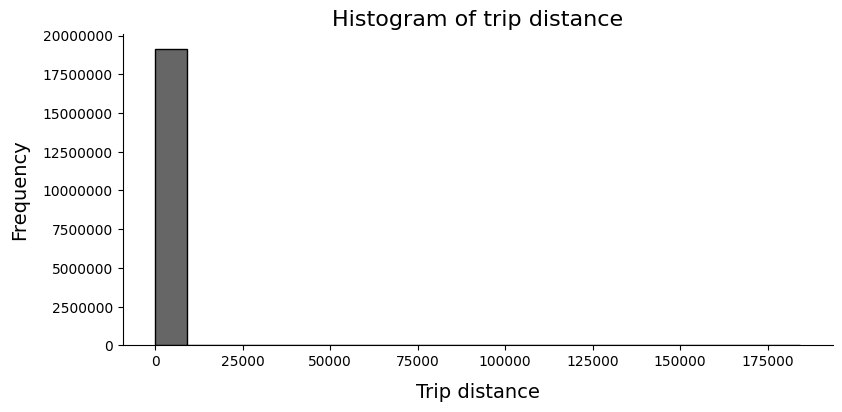

In [18]:
# Histogram of trip distance

num_ticks = 5
tick_locations = np.linspace(0, 125000, num_ticks)

plt.figure(figsize = (2,4))
sns.displot(taxi_data_na['trip_distance'], bins = 20, aspect = 2, height = 4, color = "black", alpha = 0.6)

plt.title('Histogram of trip distance', fontsize= 16)
plt.xlabel('Trip distance', fontsize = 14, labelpad = 10)
plt.ylabel('Frequency', fontsize = 14, labelpad = 10)

plt.ticklabel_format(style='plain', axis='y')
plt.savefig('Histogram_trip_distance.png', dpi = 300, bbox_inches = 'tight')
plt.show()

<Figure size 400x400 with 0 Axes>

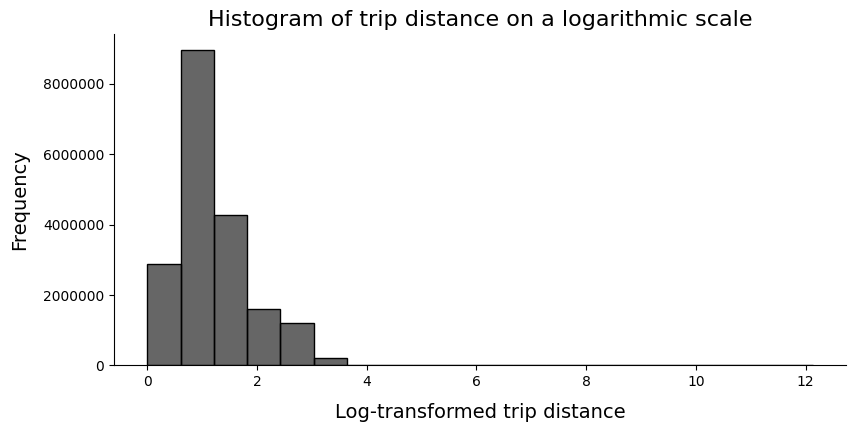

In [19]:
# Histogram of log-transformed trip distance

plt.figure(figsize = (4,4))
sns.displot(np.log(taxi_data_na['trip_distance'].values+1), bins = 20, aspect = 2, height = 4, color= "black", alpha = 0.6)

plt.title("Histogram of trip distance on a logarithmic scale", fontsize = 16)
plt.xlabel("Log-transformed trip distance", fontsize = 14, labelpad = 10)
plt.ylabel("Frequency", fontsize = 14, labelpad = 10)

plt.ticklabel_format(style='plain', axis='y')
plt.savefig('Histogram_trip_distance_log.png', dpi = 300, bbox_inches = 'tight')
plt.show()

**Findings:** <br>
The 'Trip_distance' attribute exhibits right-skewness. The plots highlight that the majority of trips were relatively short distances. Therefore, further investigation is conducted using percentile values to determine an appropriate upper bound for outlier removal.

In [20]:
# 'Trip_distance' percentiles to find an appropriate value for outlier removal

for i in range (0,100,10):
    val = taxi_data_na['trip_distance'].values
    val = np.sort(val, axis = None)
    print("{} percentile value is {}".format(i, val[int(len(val)*(float(i)/100))]))
print("100 percentile value is ", val[-1])

0 percentile value is 0.0
10 percentile value is 0.7
20 percentile value is 0.97
30 percentile value is 1.22
40 percentile value is 1.5
50 percentile value is 1.83
60 percentile value is 2.27
70 percentile value is 2.9
80 percentile value is 4.1
90 percentile value is 8.38
100 percentile value is  184340.8


As the 90th percentile value does not seem to be an outlier, further investigation is conducted on the high-end range of data (90th to 100th percentile).

In [21]:
# 90th to 100th percentile of data

for i in range(90,100):
    val = taxi_data_na["trip_distance"].values
    val = np.sort(val,axis = None)
    print("{} percentile value is {}".format(i,val[int(len(val)*(float(i)/100))]))
print ("100 percentile value is ",val[-1])

90 percentile value is 8.38
91 percentile value is 9.1
92 percentile value is 9.8
93 percentile value is 10.6
94 percentile value is 11.68
95 percentile value is 13.76
96 percentile value is 16.57
97 percentile value is 17.65
98 percentile value is 18.5
99 percentile value is 19.99
100 percentile value is  184340.8


In [22]:
# Closer look at the 99th to 100th percentile

for i in np.arange(0.0, 1.0, 0.1):
    val = taxi_data_na["trip_distance"].values
    val = np.sort(val,axis = None)
    print("{} percentile value is {}".format(99+i,val[int(len(val)*(float(99+i)/100))]))
print("100 percentile value is ",val[-1])

99.0 percentile value is 19.99
99.1 percentile value is 20.22
99.2 percentile value is 20.5
99.3 percentile value is 20.78
99.4 percentile value is 21.1
99.5 percentile value is 21.48
99.6 percentile value is 22.0
99.7 percentile value is 22.86
99.8 percentile value is 25.18
99.9 percentile value is 28.84
100 percentile value is  184340.8


The 99.9th percentile value still does not look like an outlier, as there is not much difference between the 99.8th percentile and 99.9th percentile. Therefore, we move on to a graphical analysis.

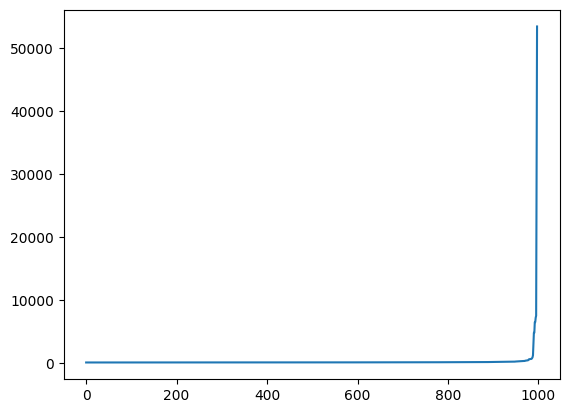

In [23]:
# Plot of the last 1000 values (excluding the last two points) of the sorted data

plt.plot(val[-1000:-2])
plt.show()

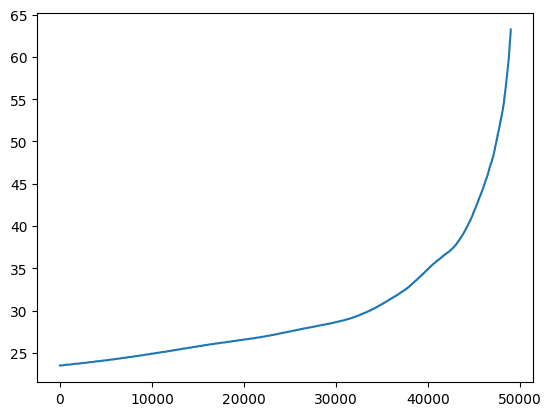

In [24]:
# Exploring a broader range of observations: Plot of the last 50,000 values (excluding the last 1000 data points)

plt.plot(val[-50000:-1000])
plt.show()

**Summary on the established reference points**: 

<ul>
    <li>The largest distance one can travel within New York City is approximately 45 miles (Distance from Wakefield, Bronx to Conference House Park, Staten Island) according to Google Maps </li>
    <li> The 99.9th percentile of trip distance is around 29 miles.</li>
    <li> The visual analysis showed a sharp increase in the values of trip distance at approximately 30 miles.</li>
</ul>

Therefore, the upper limit of trip distance is set at 30 miles as this appears reasonable regarding these references.
All trip records with trip distance <= 0 and trip distance > 30 miles will be removed in the final outlier removal process.

----------------------
#### Total amount
----------------------

In [25]:
# Payment amount values and frequencies

taxi_data_na['total_amount'].value_counts().sort_index()

-2567.80      1
-1314.80      1
-911.55       1
-900.30       1
-895.30       1
             ..
 7024.05      1
 7027.05      1
 7060.85      1
 395848.24    1
 401095.62    1
Name: total_amount, Length: 19123, dtype: int64

<Figure size 200x400 with 0 Axes>

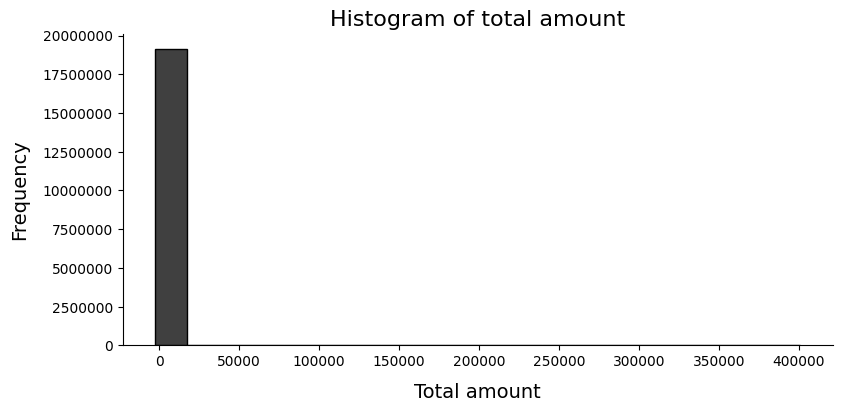

In [26]:
# Histogram of payment amount

plt.figure(figsize = (2,4))
sns.displot(taxi_data_na['total_amount'], bins = 20, aspect = 2, height = 4, color = "black")

plt.title('Histogram of total amount', fontsize= 16)
plt.xlabel('Total amount', fontsize = 14, labelpad = 10)
plt.ylabel('Frequency', fontsize = 14, labelpad = 10)

plt.ticklabel_format(style='plain', axis='y')
plt.savefig('Histogram_total_amount.png', dpi = 300, bbox_inches = 'tight')
plt.show()

<Figure size 1500x500 with 0 Axes>

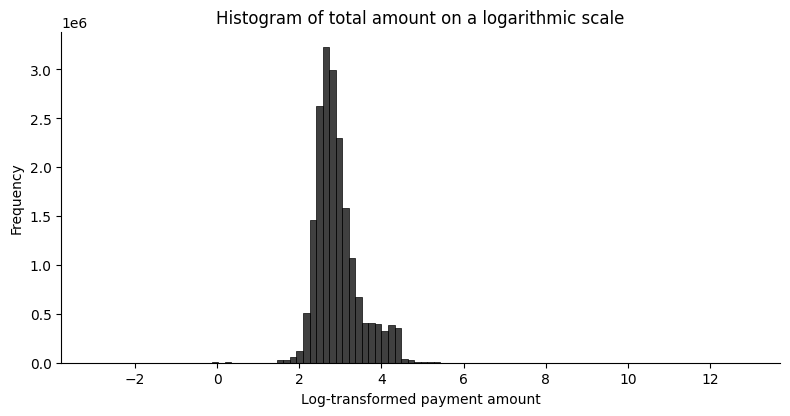

In [27]:
# Histogram of payment amount on a logarithmic scale

plt.figure(figsize = (15,5))
sns.displot(np.log(taxi_data_na['total_amount'].values+1),bins = 100, aspect = 2, height = 4, color= "black")
plt.title("Histogram of total amount on a logarithmic scale")
plt.xlabel("Log-transformed payment amount")
plt.ylabel("Frequency")
plt.show()

**Findings:**<br> Similar to 'trip_distance', the 'total_amount' attribute exhibits a highly right-skewed distribution. Consequently, we employ the same percentile methodology as applied to trip distance for further analysis.

In [28]:
# Payment amount percentiles to find an appropriate value for outlier removal 

for i in range(0,100,10):
    val_2 = taxi_data_na["total_amount"].values
    val_2 = np.sort(val_2,axis = None)
    print("{} percentile value is {}".format(i,val_2[int(len(val_2)*(float(i)/100))]))
print("100 percentile value is ",val_2[-1])

0 percentile value is -2567.8
10 percentile value is 9.8
20 percentile value is 11.3
30 percentile value is 12.42
40 percentile value is 14.0
50 percentile value is 15.36
60 percentile value is 17.25
70 percentile value is 19.8
80 percentile value is 24.36
90 percentile value is 39.55
100 percentile value is  401095.62


In [29]:
# 90th to 100th percentile of data

for i in range(90,100):
    val_2 = taxi_data_na["total_amount"].values
    val_2 = np.sort(val_2,axis = None)
    print("{} percentile value is {}".format(i,val_2[int(len(val_2)*(float(i)/100))]))
print("100 percentile value is ",val_2[-1])

90 percentile value is 39.55
91 percentile value is 42.87
92 percentile value is 46.1
93 percentile value is 49.85
94 percentile value is 54.1
95 percentile value is 59.55
96 percentile value is 64.05
97 percentile value is 70.0
98 percentile value is 75.47
99 percentile value is 79.25
100 percentile value is  401095.62


In [30]:
# Closer look at the 99th to 100th percentile

for i in np.arange(0.0, 1.0, 0.1):
    val_2 = taxi_data_na["total_amount"].values
    val_2 = np.sort(val_2,axis = None)
    print("{} percentile value is {}".format(99+i,val_2[int(len(val_2)*(float(99+i)/100))]))
print("100 percentile value is ",val_2[-1])

99.0 percentile value is 79.25
99.1 percentile value is 80.34
99.2 percentile value is 81.1
99.3 percentile value is 81.65
99.4 percentile value is 83.56
99.5 percentile value is 86.55
99.6 percentile value is 91.65
99.7 percentile value is 99.6
99.8 percentile value is 110.5
99.9 percentile value is 136.62
100 percentile value is  401095.62


The 99.9th percentile value doesn't look like an outlier, as there is not much difference between the 99.8th percentile and 99.9th percentile. Therefore, we move on to a graphical analysis.

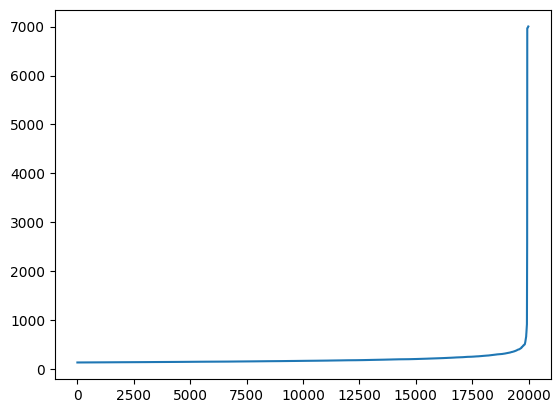

In [31]:
# Plot of the last 20,000 values (excluding the last 10 points) of the sorted data

plt.plot(val_2[-20000:-10])
plt.show()

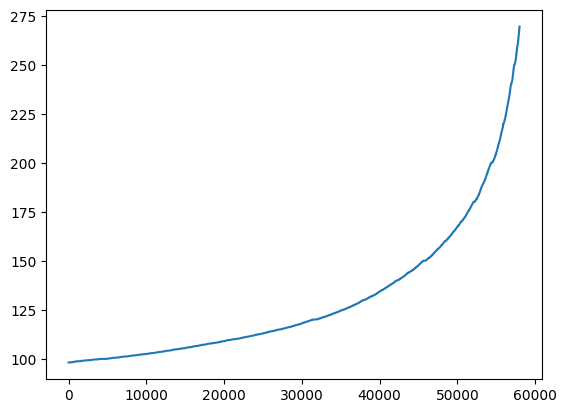

In [32]:
# Plot of the last 60,000 values (excluding the last 2,000 points) of the sorted data

plt.plot(val_2[-60000:-2000])
plt.show()

**Summary on the established reference points:**
<ul>
    <li>The 99.9th percentile of total amount is around 137.</li>
    <li>The visual analysis showed an increase in the values of trip distance at approximately 150.</li>
</ul>

Based on these reference points, the upper limit of total amount is set at 150.
In summary, all trip records with total amount <= 0 and total amount > 150 will be removed in the final outlier removal process.

----------------------
#### Pickup and dropoff datetime
----------------------

In [33]:
# Pickup datetime values and their frequencies

taxi_data_na['tpep_pickup_datetime'].value_counts().sort_index()

2001-08-23 05:34:45    1
2002-10-21 00:13:16    1
2002-10-21 00:25:44    1
2002-10-21 00:27:54    1
2002-10-21 00:50:00    1
                      ..
2022-07-01 00:36:12    1
2022-07-01 00:42:54    1
2022-07-01 00:54:47    1
2022-07-01 01:00:36    1
2023-04-18 14:30:05    1
Name: tpep_pickup_datetime, Length: 9717748, dtype: int64

In [34]:
# Dropoff datetime values and their frequencies

taxi_data_na['tpep_dropoff_datetime'].value_counts().sort_index()

2001-08-23 05:57:11    1
2002-10-21 00:24:37    1
2002-10-21 00:44:31    1
2002-10-21 00:50:06    1
2002-10-21 05:53:32    1
                      ..
2022-07-01 23:28:28    1
2022-07-01 23:48:58    1
2022-07-02 00:16:22    1
2022-07-02 02:00:27    1
2023-04-18 23:30:39    1
Name: tpep_dropoff_datetime, Length: 9712026, dtype: int64

**Findings:** <br> It is observed that there are dates outside the pre-defined period (January,01 to June,30 2022). These records will be removed in the final outlier removal step.

# Final outlier removal

In [35]:
# Define a function for the final outlier removal process

def remove_outliers(new_taxi_data):
    # Initial number of rows / trip records 
    rows_1 = new_taxi_data.shape[0]
    print("Number of trip records = ", rows_1)
    
    # Filter for entries based on the previous defined condition for outliers
    temp_data = new_taxi_data[(new_taxi_data.passenger_count == 0) | (new_taxi_data.passenger_count > 6)]
    # Print the number of outliers
    rows_2 = temp_data.shape[0]
    print("Number of outliers from passenger_count analysis: ", rows_2)
    
    # Filter for entries based on the previous defined condition for outliers
    temp_data = new_taxi_data[(new_taxi_data.PULocationID == 264) | (new_taxi_data.PULocationID == 265)]
    # Print the number of outliers
    rows_3 = temp_data.shape[0]
    print("Number of outliers from PULocationID analysis: ", rows_3)
    
    # Filter for entries based on the previous defined condition for outliers
    temp_data = new_taxi_data[(new_taxi_data.DOLocationID == 264) | (new_taxi_data.DOLocationID == 265)]
    # Print the number of outliers
    rows_4 = temp_data.shape[0]
    print("Number of outliers from DOLocationID analysis: ", rows_4)
    
    # Filter for entries based on the previous defined condition for outliers
    temp_data = new_taxi_data[(new_taxi_data.tpep_pickup_datetime < '2022-01-01')| (new_taxi_data.tpep_pickup_datetime >= '2022-07-01') | (new_taxi_data.tpep_dropoff_datetime < '2022-01-01') | (new_taxi_data.tpep_dropoff_datetime > '2022-07-01')]
    # Print the number of outliers
    rows_5 = temp_data.shape[0]
    print("Number of outliers from datetime analysis: ", rows_5)
    
    # Filter for entries based on the previous defined condition for outliers
    temp_data = new_taxi_data[(new_taxi_data.trip_distance <= 0) | (new_taxi_data.trip_distance > 30)]
    # Print the number of outliers
    rows_6 = temp_data.shape[0]
    print("Number of outliers from trip_distance analysis: ", rows_6)
    
    # Filter for entries based on the previous defined condition for outliers
    temp_data = new_taxi_data[(new_taxi_data.total_amount <= 0) | (new_taxi_data.total_amount > 150)]
    # Print the number of outliers
    rows_7 = temp_data.shape[0]
    print("Number of outliers from total_amount analysis: ", rows_7)
    
    
    # Final outlier process
    new_taxi_data = new_taxi_data.drop(new_taxi_data.index[(new_taxi_data.passenger_count == 0) | (new_taxi_data.passenger_count > 6)])

    new_taxi_data = new_taxi_data.drop(new_taxi_data.index[(new_taxi_data.PULocationID == 264) | (new_taxi_data.PULocationID == 265)])
    new_taxi_data = new_taxi_data.drop(new_taxi_data.index[(new_taxi_data.DOLocationID == 264) | (new_taxi_data.DOLocationID == 265)])
    
    new_taxi_data = new_taxi_data.drop(new_taxi_data.index[(new_taxi_data.tpep_pickup_datetime < '2022-01-01') | (new_taxi_data.tpep_pickup_datetime >= '2022-07-01')])
    new_taxi_data = new_taxi_data.drop(new_taxi_data.index[(new_taxi_data.tpep_dropoff_datetime < '2022-01-01') | (new_taxi_data.tpep_dropoff_datetime > '2022-07-01')])
                                                                                                                  
    new_taxi_data = new_taxi_data.drop(new_taxi_data.index[(new_taxi_data.trip_distance <= 0) | (new_taxi_data.trip_distance > 30)])
    new_taxi_data = new_taxi_data.drop(new_taxi_data.index[(new_taxi_data.total_amount <= 0) | (new_taxi_data.total_amount > 150)])

    
    return new_taxi_data

In [36]:
# Call the function for outlier removal
taxi_data_outl = remove_outliers(taxi_data_na)
print("Fraction of data points after removing outliers", float(len(taxi_data_outl))/len(taxi_data_na))

Number of trip records =  19145682
Number of outliers from passenger_count analysis:  403423
Number of outliers from PULocationID analysis:  212871
Number of outliers from DOLocationID analysis:  205100
Number of outliers from datetime analysis:  1625
Number of outliers from trip_distance analysis:  245726
Number of outliers from total_amount analysis:  128945
Fraction of data points after removing outliers 0.9482586204032847


In [37]:
print(taxi_data_outl.shape[0])

18155058


In [52]:
# Save dataframe in parquet format for later usage 

taxi_data_outl.to_parquet("gs://taxi_data_outl/taxi_data_outl.parquet")

# Examination of features after outlier removal

----------------------
#### Passenger count
----------------------

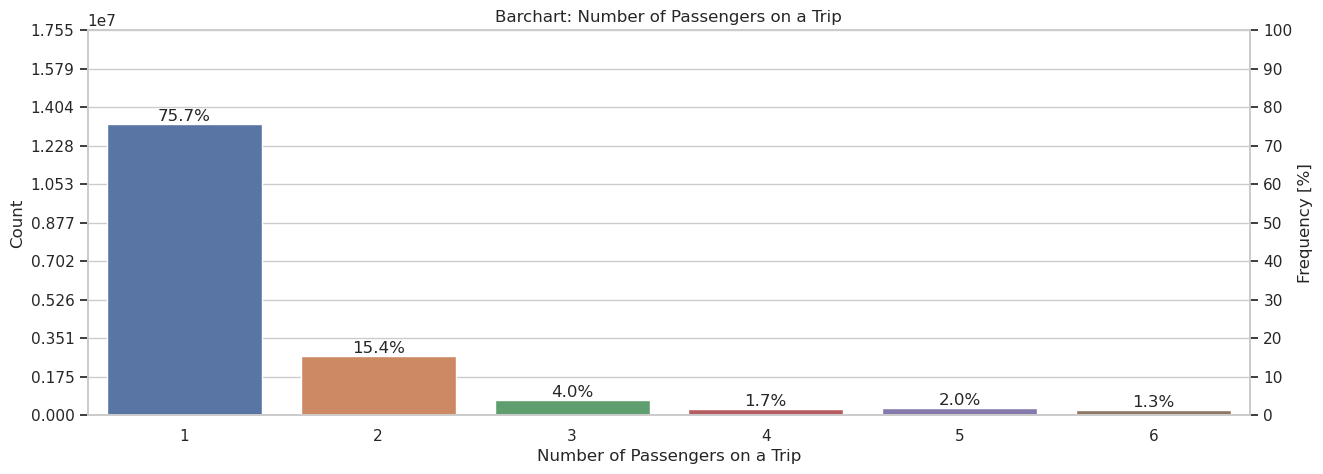

In [48]:
# Barchart of number of passengers on a trip

ncount = len(taxi_data_outl)

f = plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'passenger_count', data = taxi_data_outl)

plt.title('Barchart: Number of Passengers on a Trip')
plt.xlabel('Number of Passengers on a Trip')
plt.ylabel('Count')

ax2 = ax.twinx()
ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') 

ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.grid(None)
plt.show()

----------------------
#### Trip distance
----------------------

<Figure size 1500x500 with 0 Axes>

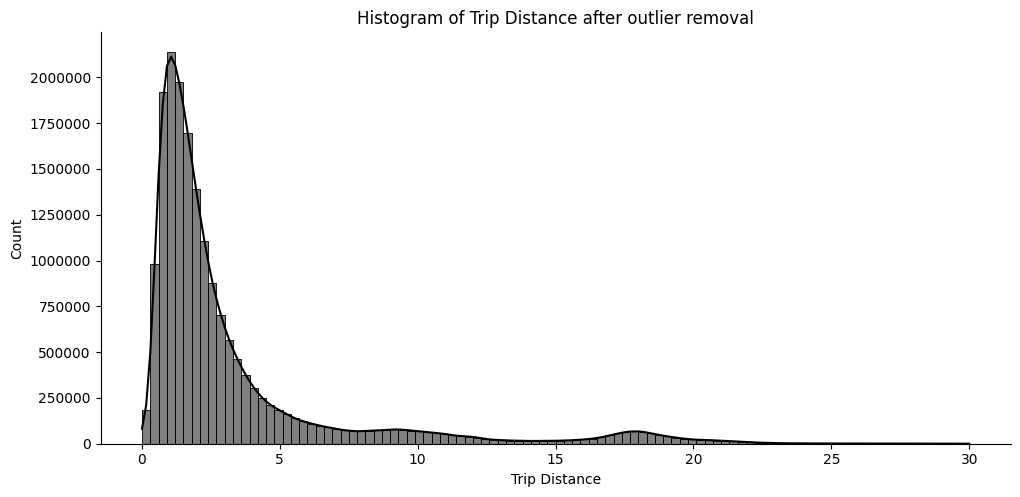

In [40]:
# Histogram and density plot of trip distance

f = plt.figure(figsize = (15,5))
sns.displot(taxi_data_outl['trip_distance'], aspect = 2, bins = 100, kde = True, color = "black")

plt.title('Histogram of Trip Distance after outlier removal')
plt.xlabel('Trip Distance')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='y',useOffset=False)  
plt.show()

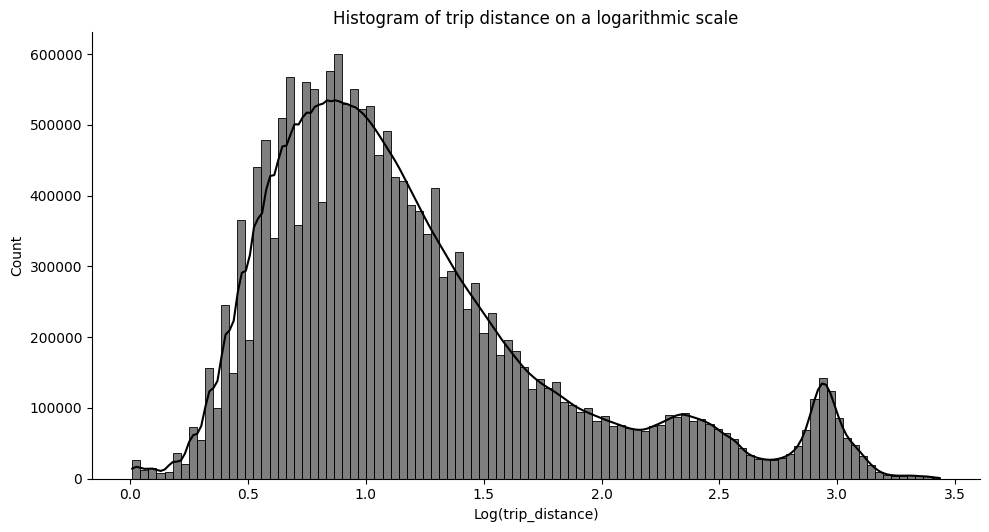

In [41]:
# Histogram and density plot of trip distance on a logarithmic scale

sns.displot(np.log(taxi_data_outl['trip_distance'].values+1),aspect = 2, bins = 100, kde = True, color = "black")

plt.title('Histogram of trip distance on a logarithmic scale')
plt.xlabel('Log(trip_distance)')
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.show()

----------------------
##### Total amount
----------------------

<Figure size 1500x500 with 0 Axes>

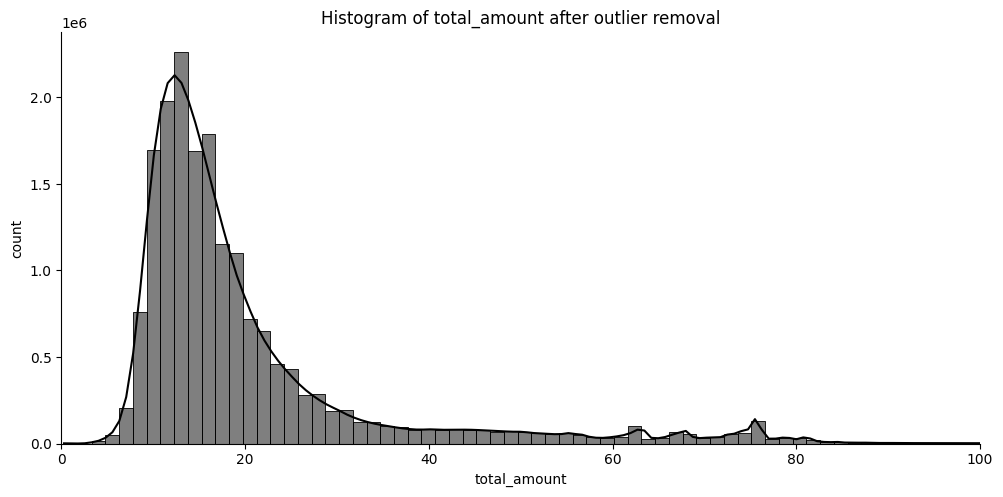

In [42]:
# Histogram and density plot of total fare amount

f = plt.figure(figsize = (15,5))
sns.displot(taxi_data_outl['total_amount'], aspect = 2, bins = 100, kde = True, color = "black")

plt.title('Histogram of total_amount after outlier removal')
plt.xlabel('total_amount')
plt.xlim([0, 100])
plt.ylabel('count')
plt.show()

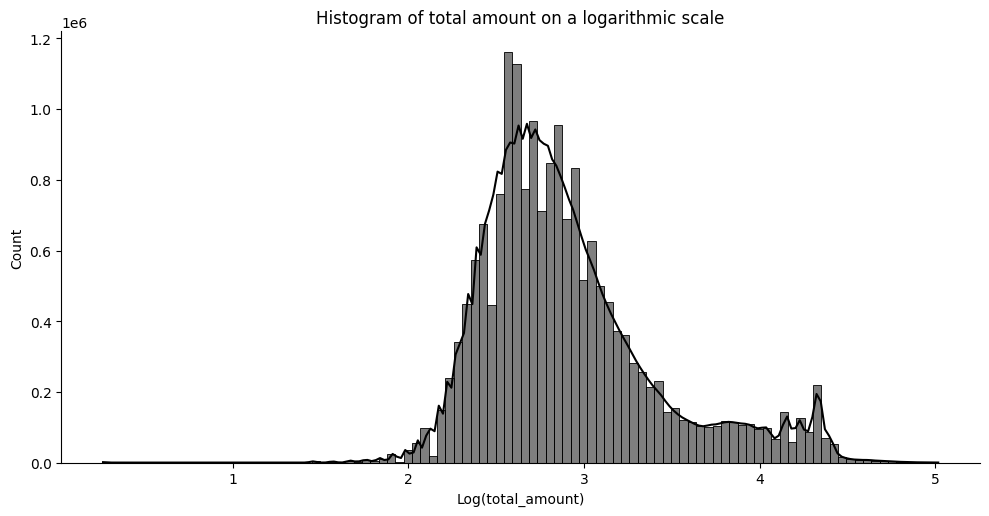

In [43]:
# Histogram and density plot of total amount on a logarithmic scale

sns.displot(np.log(taxi_data_outl['total_amount'].values+1),aspect = 2, bins = 100, kde = True, color = "black")

plt.title('Histogram of total amount on a logarithmic scale')
plt.xlabel('Log(total_amount)')
plt.show()